In [1]:
import torch
import math
#from dlc_practical_prologue import *
#torch.set_grad_enabled(False)

In [2]:
#INTERESTING FACT: WHEN COMPUTING THE BATCH GRADIENT PYTORCH DOES NOT TAKE THE SUM OF THE GRADIENTA OF SINGLE DATA POINTS
#BUT THE MEAN. I LEART AT THE EXPENSE OF ABOUT 1H LOL 

In [3]:
class Parameter():
    def __init__(self):
        self.name = ''
        self.data = None
        self.grad = None

In [4]:
class Module(object):
    def forward (self, *input):
        raise NotImplementedError
        
    def backward ( self , * gradwrtoutput ) :
        raise NotImplementedError
    
    def get_parameters( self ) :
        return []   

In [5]:
class Losses(object):        
    def forward():
        return NotImplementedError
    def backward():
        NotImplementedError

In [6]:
class Optimizer(object):
    def zero_grad(self):
        for parameter in self.param : 
            parameter.grad = 0
            
    def step(self):
        raise NotImplementedError

In [7]:
class SGD(Optimizer):

    def __init__(self,lr,max_iter, parameters, momentum = True ,beta= 0.9) :   
        super().__init__()
        self.eta = lr   # learning rate is fixed
        self.maxStep = max_iter
        self.param = parameters
        self.number_step = 0
        # Initialize momentum to zero
        self.v = self.param.copy()
        self.v = []
        for i in range(len(self.param)):
            size_param = self.param[i].data.size()
            v_init= torch.zeros(size_param)
            (self.v).append(v_init)
        self.beta = beta
        self.momentum = momentum

    def step(self): 

        if self.number_step <=self.maxStep:
            for parameter, V in zip(self.param, self.v):
                
                if self.momentum :    # SGD + Momentum
                    V = self.beta * V + self.eta * parameter.grad   
                    parameter.data = parameter.data - V
                else :                # SGD 
                    parameter.data = parameter.data - self.eta * parameter.grad
           
            self.number_step = self.number_step + 1
        return self.param

In [8]:
class Linear(Module):
    
    def __init__(self, input_dim, out_dim, bias = True):
        super().__init__()
        std = 1/math.sqrt(input_dim)
        self.weight = Parameter()
        self.parameters = []
        
        self.weight.data = torch.rand(out_dim, input_dim)
        self.weight.data = 2*std*self.weight.data - std
        self.weight.name = 'weight'
        self.parameters += [self.weight]
        
        self.with_bias = bias
        if bias :
            self.bias = Parameter()
            self.bias.data = torch.rand(out_dim)
            self.bias.data = 2*std*self.bias.data - std
            self.bias.data = self.bias.data.unsqueeze(0)
            self.bias.name = 'bias'
            self.parameters +=[self.bias]
            
        self.x = None
              
    def forward(self, x):
        self.x = x
        self.batch_size = x.shape[0]
        return self.x.mm(self.weight.data.T) + self.bias.data
        
    def backward(self, prev_grad):
        
        prev_grad = prev_grad.view(self.batch_size, -1, 1)
        #print(prev_grad.shape)
        if self.x is None:
            raise CallForwardFirst
        
        if self.weight.grad is None:
            self.weight.grad = torch.zeros_like(self.weight.data)
        
        grad_on_batch = prev_grad.view(self.batch_size, -1, 1)*self.x.view(self.batch_size, 1, -1)
        self.weight.grad += grad_on_batch.mean(0)
        
        if self.with_bias:
            if self.bias.grad is None:
                self.bias.grad = torch.zeros_like(self.bias.data)
            grad_on_batch = prev_grad.view(self.batch_size, -1)
            self.bias.grad += grad_on_batch.mean(0)
        
        #if the output has dimension one, squeezing creates problems
        if prev_grad.shape[1]>1:
            prev_grad = prev_grad.squeeze()
        next_grad = prev_grad@self.weight.data
        return next_grad.squeeze()
    
    def get_parameters(self):
        return self.parameters    

In [9]:
class Tanh(Module):
    def __init__(self):
        self.x = None
    
    def forward (self, x):
        self.x = x
        return torch.tanh(x)
        
    def backward ( self, prev_grad) :
        if self.x is None:
            raise CallForwardFirst
            
        def d(x):
            return 4 * (x.exp() + x.mul(-1).exp()).pow(-2)
        
        return d(self.x)*prev_grad
            

In [10]:
class ReLu(Module):
    def __init__(self):
        self.x = None
    
    def forward (self, x):
        self.x = x
        x[x<0]=0
        return x
        
    def backward ( self, prev_grad) :
        if self.x is None:
            raise CallForwardFirst
            
        def d(x):
            x[x<0]=0
            x[x>0]=1
            return x
        
        return d(self.x)*prev_grad
            

In [11]:
#Doesn't work and we have to output 1 unit so it's useless
class Softmax(Module):
    def __init__(self):
        self.x = None
    
    def forward (self, x):
        self.x = x
        return torch.softmax(x,1)
        
    def backward ( self, prev_grad) :
        if self.x is None:
            raise CallForwardFirst
            
        def d(x):
            return -x.mm(x.transpose(0,1))+torch.diag(x)
        
        return d(self.x)*prev_grad

In [12]:
#Doesn't work and we have to output 1 unit so it's useless
class Sigmoid(Module):
    def __init__(self):
        self.x = None
    
    def forward (self, x):
        self.x = x
        return torch.sigmoid(x)
        
    def backward ( self, prev_grad) :
        if self.x is None:
            raise CallForwardFirst
            
        def d(x):
            y=torch.sigmoid(x)
            return y*(1-y)
        
        return d(self.x)*prev_grad

In [13]:
class MSE(Losses):
    # Attention! Works well only when the vectors provided are of the form [batch_size, vector dimension]
    # Otherwise it doesn know what dimesion to pick for the mean computation
    # I'll fix this later
    def __init__(self):
        self.x = None
    def forward(self, x, t):
        self.x = x
        self.t = t
        return (x - t).pow(2).mean()
    
    def backward(self):
        if self.x == None or self.t == None:
            raise CallForwardFirst
        return 2 * (self.x - self.t)/self.x.shape[1]

In [14]:
class Sequential(object):
    def __init__(self, modules):
        super().__init__()
        self.modules=modules
        self.parameters = []
        for m in self.modules:
            param = m.get_parameters()
            if param:
                self.parameters += param
        
    def forward(self,x):
        for m in self.modules:
            x=m.forward(x)
        return x
    
    def backward(self, loss_grad):
        x = loss_grad
        for m in reversed(self.modules):
            #print(m)
            x = m.backward(x)
            
    def get_parameters(self):
        return self.parameters

    def set_parameters(self , params):
        self.parameters = params
        

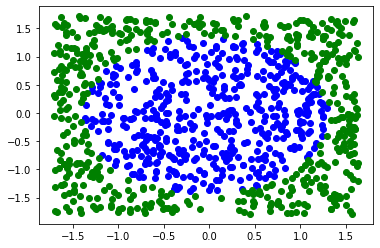

In [15]:
def generate_disc_set(nb):
    input_ = torch.empty(nb, 2).uniform_(0, 1)
    target = (input_-0.5).pow(2).sum(1).sub(1 / (math.pi*2)).sign().add(1).div(2).long()
    return input_, target
input_data, output_data=generate_disc_set(1000)
output_data=1-output_data
input_data-=input_data.mean(0)
input_data/=input_data.std(0)
import matplotlib.pyplot as plt
plt.plot(input_data[:,0][output_data==1],input_data[:,1][output_data==1],'bo')
plt.plot(input_data[:,0][output_data!=1],input_data[:,1][output_data!=1],'go')

In [16]:
#output_data = 2*output_data -1
print(input_data, input_data.shape, output_data.shape)

tensor([[ 0.7582, -1.5591],
        [-0.5533, -0.5972],
        [ 1.5560,  0.2821],
        ...,
        [ 1.4986, -1.4743],
        [-1.5421, -0.9109],
        [-0.8700, -1.6964]]) torch.Size([1000, 2]) torch.Size([1000])


In [17]:
#we should use one hot label embedding with MSELoss. Hence it is necessary to implement a Softmax
#Maybe we should also implement CrossEntropyLoss
#print(input_data.shape, output_data.shape)
#output_data = convert_to_one_hot_labels(input_data, output_data)
#print(input_data.shape, output_data.shape)

In [18]:
#handmade sequential linear + relu 
linear1 = Linear(2, 25, True)
linear2 = Linear(25,25,True)
linear3 = Linear(25,1,True)
sigma1 = Tanh()
sigma2 = Tanh()
sigma3 = Tanh()
loss = MSE()

net = Sequential([
    linear1, 
    sigma1 ,
    linear2,
    sigma2 ,
    linear3,
    sigma3 ,
])

In [19]:
optimizer = SGD(lr = 1e-4,max_iter = 100, parameters = net.get_parameters())
n=10**2
N=output_data.shape[0]
for t in range(n):
    optimizer.zero_grad()
    acc_loss=0
    permuted_index = torch.randperm(input_data.size()[0])
    input_data_shuffled = input_data[permuted_index]
    output_data_shuffled = output_data[permuted_index]
    for i in range(N):
        x=input_data_shuffled[i]
        y=2*output_data_shuffled[i]-1
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = net.forward(x.unsqueeze(0))
        # Compute and print loss.
        acc_loss += loss.forward(y_pred,y.unsqueeze(0))
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        net.backward(loss.backward())

    # Calling the step function on an Optimizer makes an update to its parameters
    new_par = optimizer.step()
    #print(len(new_par))
    net.set_parameters(new_par)
    
    
    if t%10==0:
        print(t, '   MSE loss = ' , acc_loss.item())

0    MSE loss =  1026.8297119140625
10    MSE loss =  972.5297241210938
20    MSE loss =  941.5697631835938
30    MSE loss =  902.7471313476562
40    MSE loss =  850.5894165039062
50    MSE loss =  782.9170532226562
60    MSE loss =  703.6536865234375
70    MSE loss =  621.3328857421875
80    MSE loss =  542.839111328125
90    MSE loss =  472.0589294433594


In [20]:
correct=0
for i in range(output_data.shape[0]):
        x=input_data[i]
        y=2*output_data[i]-1
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = net.forward(x.unsqueeze(0))
        if abs(y_pred-output_data[i])<1:
            correct+=1
print('Correct predictions after '+str(n)+' training steps: '+str(correct/N*100)+' %')

Correct predictions after 100 training steps: 96.5 %


In [21]:
#Reinitialize net
#handmade sequential linear + relu 
linear1 = Linear(2, 25, True)
linear2 = Linear(25,25,True)
linear3 = Linear(25,1,True)
sigma1 = Tanh()
sigma2 = Tanh()
sigma3 = Tanh()
loss = MSE()

net = Sequential([
    linear1, 
    sigma1 ,
    linear2,
    sigma2 ,
    linear3,
    sigma3 ,
])

In [22]:
optimizer = SGD(lr = 1e-1,max_iter = 100, parameters = net.get_parameters())
n=10**2
N=output_data.shape[0]
batch_size = 100
for t in range(n):
    acc_loss=0
    permuted_index = torch.randperm(input_data.size()[0])
    input_data_shuffled = input_data[permuted_index]
    output_data_shuffled = output_data[permuted_index]
    for b in range(0, N, batch_size):
        predictions = net.forward(input_data_shuffled[b:b+batch_size])
        l= loss.forward(predictions, output_data_shuffled[b:b+batch_size].unsqueeze(-1))
        acc_loss += l
        optimizer.zero_grad()
        
        net.backward(loss.backward())
        
        new_par = optimizer.step()
        net.set_parameters(new_par)
    
    print(t, '   MSE loss = ' , acc_loss.item())

0    MSE loss =  2.797254800796509
1    MSE loss =  2.191330909729004
2    MSE loss =  2.127686023712158
3    MSE loss =  2.063326835632324
4    MSE loss =  2.0039925575256348
5    MSE loss =  1.914603590965271
6    MSE loss =  1.8399988412857056
7    MSE loss =  1.7531986236572266
8    MSE loss =  1.661909580230713
9    MSE loss =  1.5706528425216675
10    MSE loss =  1.5355052947998047
11    MSE loss =  1.529868721961975
12    MSE loss =  1.529868721961975
13    MSE loss =  1.529868721961975
14    MSE loss =  1.5298686027526855
15    MSE loss =  1.5298686027526855
16    MSE loss =  1.529868721961975
17    MSE loss =  1.5298688411712646
18    MSE loss =  1.5298686027526855
19    MSE loss =  1.5298688411712646
20    MSE loss =  1.5298686027526855
21    MSE loss =  1.529868721961975
22    MSE loss =  1.5298686027526855
23    MSE loss =  1.529868721961975
24    MSE loss =  1.5298686027526855
25    MSE loss =  1.529868721961975
26    MSE loss =  1.5298686027526855
27    MSE loss =  1.5298

In [23]:
correct=0
for i in range(output_data.shape[0]):
        x=input_data[i]
        y=2*output_data[i]-1
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = net.forward(x.unsqueeze(0))
        if abs(y_pred-output_data[i])<1:
            correct+=1
print('Correct predictions after '+str(n)+' training steps: '+str(correct/N*100)+' %')

Correct predictions after 100 training steps: 100.0 %


In [24]:
#handmade sequential linear + relu with sigmoid to end and no batches
linear1 = Linear(2, 25, True)
linear2 = Linear(25,25,True)
linear3 = Linear(25,1,True)
sigma1 = ReLu()
sigma2 = ReLu()
sigma3 = Sigmoid()
loss = MSE()

net = Sequential([
    linear1, 
    sigma1 ,
    linear2,
    sigma2 ,
    linear3,
    sigma3 ,
])
optimizer = SGD(lr = 1e-4,max_iter = 100, parameters = net.get_parameters())
n=10**2
N=output_data.shape[0]
for t in range(n):
    optimizer.zero_grad()
    acc_loss=0
    permuted_index = torch.randperm(input_data.size()[0])
    input_data_shuffled = input_data[permuted_index]
    output_data_shuffled = output_data[permuted_index]
    for i in range(N):
        x=input_data_shuffled[i]
        y=output_data_shuffled[i]
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = net.forward(x.unsqueeze(0))
        # Compute and print loss.
        acc_loss += loss.forward(y_pred,y.unsqueeze(0))
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        net.backward(loss.backward())

    # Calling the step function on an Optimizer makes an update to its parameters
    new_par = optimizer.step()
    #print(len(new_par))
    net.set_parameters(new_par)
    
    
    if t%10==0:
        print(t, '   MSE loss = ' , acc_loss.item())
    
correct=0
for i in range(output_data.shape[0]):
        x=input_data[i]
        y=2*output_data[i]-1
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = net.forward(x.unsqueeze(0))
        if abs(y_pred-output_data[i])<1:
            correct+=1
print('Correct predictions after '+str(n)+' training steps: '+str(correct/N*100)+' %')

0    MSE loss =  250.3065643310547
10    MSE loss =  247.48760986328125
20    MSE loss =  245.02781677246094
30    MSE loss =  242.7385711669922
40    MSE loss =  240.51614379882812
50    MSE loss =  238.26028442382812
60    MSE loss =  235.92877197265625
70    MSE loss =  233.47219848632812
80    MSE loss =  230.87245178222656
90    MSE loss =  228.10482788085938
Correct predictions after 100 training steps: 100.0 %


In [25]:
#handmade sequential linear + relu with softmax with batches
linear1 = Linear(2, 25, True)
linear2 = Linear(25,25,True)
linear3 = Linear(25,1,True)
sigma1 = ReLu()
sigma2 = ReLu()
sigma3 = Sigmoid()
loss = MSE()

net = Sequential([
    linear1, 
    sigma1 ,
    linear2,
    sigma2 ,
    linear3,
    sigma3 ,
])
optimizer = SGD(lr = 1e-1,max_iter = 100, parameters = net.get_parameters())
n=10**2
N=output_data.shape[0]
batch_size = 100
for t in range(n):
    acc_loss=0
    permuted_index = torch.randperm(input_data.size()[0])
    input_data_shuffled = input_data[permuted_index]
    output_data_shuffled = output_data[permuted_index]
    for b in range(0, N, batch_size):
        predictions = net.forward(input_data_shuffled[b:b+batch_size])
        l= loss.forward(predictions, output_data_shuffled[b:b+batch_size].unsqueeze(-1))
        acc_loss += l
        optimizer.zero_grad()
        
        net.backward(loss.backward())
        
        new_par = optimizer.step()
        net.set_parameters(new_par)
    
    print(t, '   MSE loss = ' , acc_loss.item())
    
correct=0
for i in range(output_data.shape[0]):
        x=input_data[i]
        y=2*output_data[i]-1
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = net.forward(x.unsqueeze(0))
        if abs(y_pred-output_data[i])<1:
            correct+=1
print('Correct predictions after '+str(n)+' training steps: '+str(correct/N*100)+' %')

0    MSE loss =  2.4857826232910156
1    MSE loss =  2.464448928833008
2    MSE loss =  2.446307420730591
3    MSE loss =  2.427915096282959
4    MSE loss =  2.411731719970703
5    MSE loss =  2.3950605392456055
6    MSE loss =  2.378262758255005
7    MSE loss =  2.3612921237945557
8    MSE loss =  2.3435561656951904
9    MSE loss =  2.325162172317505
10    MSE loss =  2.31282114982605
11    MSE loss =  2.3122923374176025
12    MSE loss =  2.3122923374176025
13    MSE loss =  2.3122920989990234
14    MSE loss =  2.3122923374176025
15    MSE loss =  2.3122920989990234
16    MSE loss =  2.3122923374176025
17    MSE loss =  2.3122923374176025
18    MSE loss =  2.3122925758361816
19    MSE loss =  2.3122923374176025
20    MSE loss =  2.3122923374176025
21    MSE loss =  2.3122923374176025
22    MSE loss =  2.3122920989990234
23    MSE loss =  2.3122923374176025
24    MSE loss =  2.3122925758361816
25    MSE loss =  2.3122923374176025
26    MSE loss =  2.3122925758361816
27    MSE loss =  2